# Preparing Dataset

In [1]:
!pip install gdown 
!pip install split-folders

In [2]:
!gdown --id 1gRbjr1NYxBzAG7tmahbDzOyp2BrpT3_W

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1gRbjr1NYxBzAG7tmahbDzOyp2BrpT3_W
From (redirected): https://drive.google.com/uc?id=1gRbjr1NYxBzAG7tmahbDzOyp2BrpT3_W&confirm=t&uuid=99a58a60-4076-4bb6-9f11-eee2bb10c719
To: /kaggle/working/data.zip
100%|████████████████████████████████████████| 161M/161M [00:04<00:00, 34.6MB/s]


In [3]:
!unzip data.zip 

Archive:  data.zip
   creating: data/
   creating: data/Black Soil/
  inflating: data/Black Soil/black.jpg  
  inflating: data/Black Soil/black12.jpg  
  inflating: data/Black Soil/black1.jpeg  
  inflating: data/Black Soil/depositphotos_113297290-stock-photo-black-soil-texture.jpg  
  inflating: data/Black Soil/black2.jpeg  
  inflating: data/Black Soil/18_jpg.rf.796f2a9439c754fd2df4321948bba4df.jpg  
  inflating: data/Black Soil/3_jpg.rf.70abf3d7e1be1bc9750aa688a1ab7bbe.jpg  
  inflating: data/Black Soil/4_jpg.rf.b44c7df6045e5c56e964c305e3f7adfe.jpg  
  inflating: data/Black Soil/10_jpg.rf.23efee88388171480540f8dcf4a9272e.jpg  
  inflating: data/Black Soil/10_jpg.rf.8f1792485f20956c368d6c20f9f9a9dd.jpg  
  inflating: data/Black Soil/10_jpg.rf.92961b7e6e32bc7c9588fc6680ec7bb9.jpg  
  inflating: data/Black Soil/11_jpg.rf.02501fa114ed1becf091c8bf006fd2a1.jpg  
  inflating: data/Black Soil/11_jpg.rf.b54333efceb41caa4d04b34d9c27475d.jpg  
  inflating: data/Black Soil/11_jpg.rf.c8b99236fda

In [28]:
# SPLIT DATA INTO TRAINING AND VALIDATION SET
import splitfolders
splitfolders.ratio(
    "data", 
    output="dataset",
    ratio=(.8, .2), 
    group_prefix=None, 
    move=False
)

Copying files: 2093 files [00:00, 5186.85 files/s]


# Depedencies

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


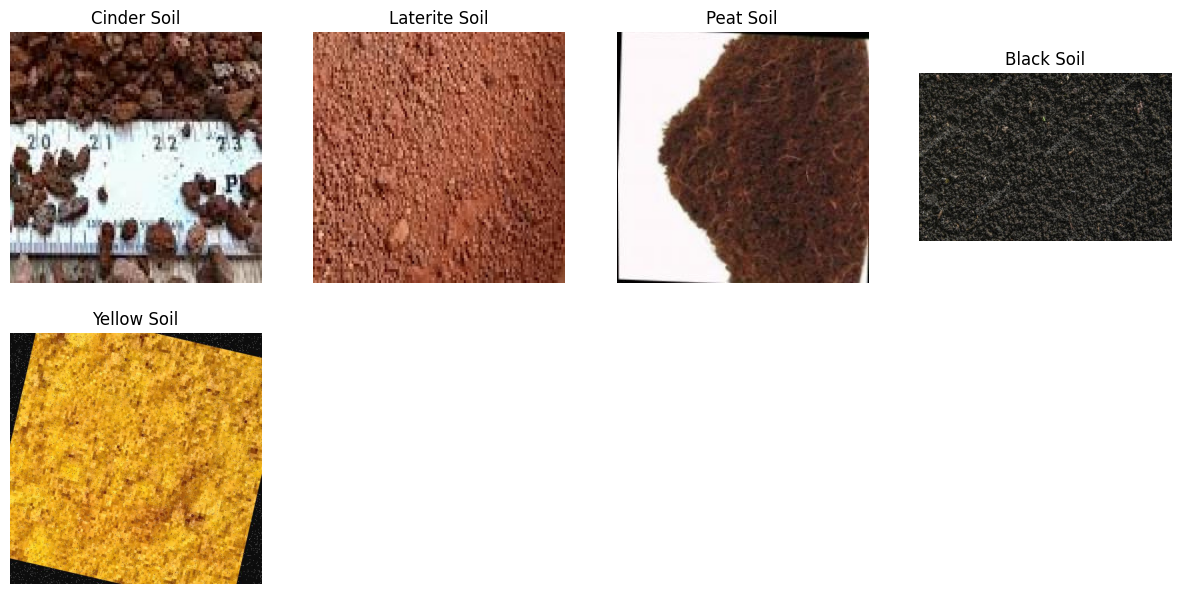

In [29]:
fig = plt.figure(figsize=(15,15))

image_folder = "data"
for index, label in enumerate(os.listdir(image_folder)):
  img = os.listdir(os.path.join(image_folder,label))[0]
  img = cv2.imread(os.path.join(image_folder,label,img))

  fig.add_subplot(4, 4, index+1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(label)
  plt.axis("off")
plt.show()

# Image Generator

In [30]:
TRAINING_DIR = "dataset/train"
training_datagen = ImageDataGenerator(
    rescale=(1/255.),
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill mode for newly created pixels
)

training_generator = training_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(160,160),
    class_mode='categorical',
)

VALIDATION_DIR = "dataset/val"
validation_datagen = ImageDataGenerator(
    rescale=(1/255.),
)

validation_generator = validation_datagen.flow_from_directory(
    directory=VALIDATION_DIR,
    target_size=(160,160),
    class_mode='categorical',
)

Found 1672 images belonging to 5 classes.
Found 421 images belonging to 5 classes.


# Building Model

In [45]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=3, input_shape=(160,160,3), activation='relu'),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(3,3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [47]:
cp = tf.keras.callbacks.ModelCheckpoint(
    "soil.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=7, verbose=1,
) 

In [48]:
history = model.fit(training_generator, epochs=100, validation_data=validation_generator, callbacks=[cp,es])

Epoch 1/100
53/53 [==============================] - ETA: 0s - loss: 1.4812 - accuracy: 0.3182
Epoch 1: val_loss improved from inf to 1.13751, saving model to soil.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 8s 122ms/step - loss: 1.4812 - accuracy: 0.3182 - val_loss: 1.1375 - val_accuracy: 0.4489
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 1.1629 - accuracy: 0.4623
Epoch 2: val_loss improved from 1.13751 to 0.98631, saving model to soil.h5
53/53 [==============================] - 6s 120ms/step - loss: 1.1629 - accuracy: 0.4623 - val_loss: 0.9863 - val_accuracy: 0.5962
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.5365
Epoch 3: val_loss improved from 0.98631 to 0.93789, saving model to soil.h5
53/53 [==============================] - 6s 121ms/step - loss: 1.0524 - accuracy: 0.5365 - val_loss: 0.9379 - val_accuracy: 0.6556
Epoch 4/100
53/53 [==============================] - ETA: 0s - loss: 0.9959 - accuracy: 0.5831
Epoch 4: val_loss improved from 0.93789 to 0.78884, saving model to soil.h5
53/53 [==============================] - 6s 120ms/step - loss: 0.9959 - accuracy: 0.5831 - val

In [49]:
best_model = tf.keras.models.load_model("soil.h5")
best_model.evaluate(validation_generator)

14/14 [==============================] - 1s 83ms/step - loss: 0.3315 - accuracy: 0.8979


[0.3314998149871826, 0.8978622555732727]

In [73]:
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_vall_loss)
best_acc = history.history['val_accuracy'][best_epoch]

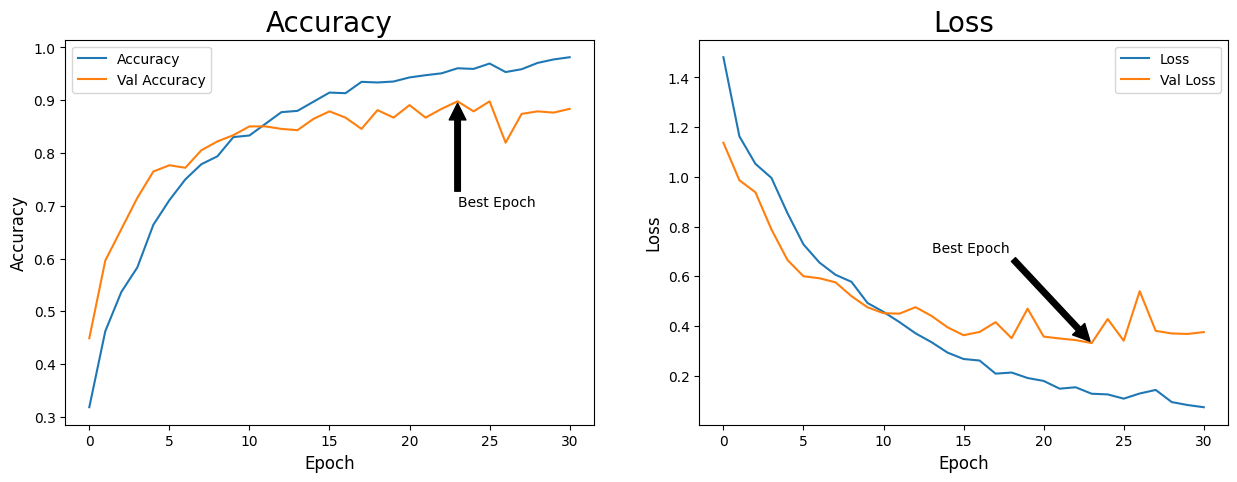

In [78]:
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(15,5))
axs1.plot(history.history['accuracy'])
axs1.plot(history.history['val_accuracy'])
axs1.legend(['Accuracy','Val Accuracy'])
axs1.set_xlabel('Epoch', fontsize=12)
axs1.set_ylabel('Accuracy', fontsize=12)
axs1.set_title('Accuracy', fontsize=20)
axs1.annotate(
    'Best Epoch', xy=(best_epoch, best_acc), xytext=(best_epoch, best_acc-0.2), 
    arrowprops=dict(facecolor='black', shrink=0.02))


axs2.plot(history.history['loss'])
axs2.plot(history.history['val_loss'])
axs2.legend(['Loss','Val Loss'])
axs2.set_xlabel('Epoch', fontsize=12)
axs2.set_ylabel('Loss', fontsize=12)
axs2.set_title('Loss', fontsize=20)
axs2.annotate(
    'Best Epoch', xy=(best_epoch, best_val_loss), xytext=(best_epoch-10, best_acc-0.2), 
    arrowprops=dict(facecolor='black', shrink=0.02))
plt.show()